In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('/Users/amulya/Desktop/Capstone/DSCI-601-Amy/Data/AKAM.csv', parse_dates=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6080 non-null   object 
 1   TICKER       6080 non-null   object 
 2   CUSIP        6080 non-null   object 
 3   COMNAM       6080 non-null   object 
 4   RET          6080 non-null   float64
 5   VOL_CHANGE   6080 non-null   float64
 6   BA_SPREAD    6080 non-null   float64
 7   ILLIQUIDITY  6080 non-null   float64
 8   sprtrn       6080 non-null   float64
 9   TURNOVER     6080 non-null   float64
 10  PRC          6080 non-null   float64
 11  SHROUT       6080 non-null   float64
 12  MARKET_CAP   6080 non-null   float64
 13  TRAN_COST    6080 non-null   float64
 14  ASK          6080 non-null   float64
 15  BID          6080 non-null   float64
dtypes: float64(12), object(4)
memory usage: 760.1+ KB


In [6]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [11]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

### ADF Test
statistical test used to check whether a given time series is stationary or not. Stationarity is a crucial property in time series analysis, which implies that the statistical properties of a series (e.g., mean, variance, and autocorrelation) do not change over time.



In [12]:
def adf_test(series, title=''):
    """
    Perform the Augmented Dickey-Fuller test and print the results.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")
    print('-'*50)

In [13]:
for column in numeric_df.columns:
    adf_test(numeric_df[column], title=f'{column}')

Augmented Dickey-Fuller Test: RET
ADF Test Statistic : -13.290641327184447
p-value : 7.374883701861864e-25
#Lags Used : 32
Number of Observations Used : 6047
Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data is stationary.
--------------------------------------------------
Augmented Dickey-Fuller Test: VOL_CHANGE
ADF Test Statistic : -32.60738538545454
p-value : 0.0
#Lags Used : 7
Number of Observations Used : 6072
Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data is stationary.
--------------------------------------------------
Augmented Dickey-Fuller Test: BA_SPREAD
ADF Test Statistic : -2.4535925374246714
p-value : 0.12717778861237122
#Lags Used : 33
Number of Observations Used : 6046
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.
--------------------------------------------------
Augmented Dickey-Fuller Test: ILLIQUIDITY
ADF Test Statistic : -12.880041591533244
p-

### Modeling

In [22]:
model = VAR(numeric_df)
model_fitted = model.fit(maxlags=4)

/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
forecast = model_fitted.forecast(numeric_df.values[-model_fitted.k_ar:], steps=5)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=numeric_df.index[-1] + pd.Timedelta(days=1), periods=5, freq='D'), columns=numeric_df.columns)


In [18]:
# plt.figure(figsize=(12, 8))
# for i, column in enumerate(numeric_df.columns, 1):
#     plt.subplot(len(numeric_df.columns), 1, i)
#     plt.plot(numeric_df.index, numeric_df[column], label='Actual')
#     plt.plot(forecast_df.index, forecast_df[column], label='Forecast', linestyle='--')
#     plt.title(f'{column} - Actual vs Forecast')
#     plt.legend()

# plt.tight_layout()
# plt.show()

In [17]:
print("Forecasted Values for the Next 5 Days:")
print(forecast_df)

Forecasted Values for the Next 5 Days:
                 RET  VOL_CHANGE  BA_SPREAD   ILLIQUIDITY    sprtrn  TURNOVER  \
2023-12-30  0.000788    0.113007   0.000389  7.840124e-10  0.000353  6.034907   
2023-12-31 -0.001634    0.113190   0.000534 -8.367075e-10  0.000320  5.534939   
2024-01-01 -0.000130    0.108978   0.000376  3.759421e-10  0.000205  6.091597   
2024-01-02 -0.001464    0.112685   0.000508 -7.151724e-11  0.000436  5.638202   
2024-01-03 -0.001342    0.121841   0.000459 -1.128944e-10  0.000450  5.965359   

                   PRC         SHROUT    MARKET_CAP  TRAN_COST         ASK  \
2023-12-30  118.343115  150829.705265  1.784997e+07   0.039239  118.395900   
2023-12-31  118.273402  150838.778948  1.784139e+07   0.035265  118.318858   
2024-01-01  118.288587  150825.187118  1.784143e+07   0.032724  118.326975   
2024-01-02  118.165244  150828.305422  1.782824e+07   0.034937  118.205060   
2024-01-03  118.034179  150826.451432  1.781397e+07   0.033648  118.071873   

     

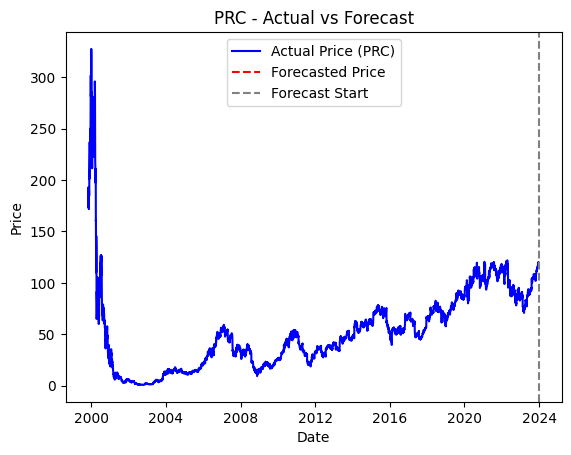

In [29]:
plt.plot(numeric_df.index, numeric_df['PRC'], label='Actual Price (PRC)', color='blue')
plt.plot(forecast_df.index, forecast_df['PRC'], label='Forecasted Price', linestyle='--', color='red')
plt.axvline(x=numeric_df.index[-1], color='gray', linestyle='--', label='Forecast Start')  # Mark the forecast start point
plt.title('PRC - Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [28]:
forecast_df['PRC']

2023-12-30    118.343115
2023-12-31    118.273402
2024-01-01    118.288587
2024-01-02    118.165244
2024-01-03    118.034179
Freq: D, Name: PRC, dtype: float64

In [30]:
print(f"Actual Data Range: {numeric_df.index[0]} to {numeric_df.index[-1]}")
print(f"Forecast Data Range: {forecast_df.index[0]} to {forecast_df.index[-1]}")


Actual Data Range: 1999-11-01 00:00:00 to 2023-12-29 00:00:00
Forecast Data Range: 2023-12-30 00:00:00 to 2024-01-03 00:00:00
